In [99]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import soundfile as sf
import noisereduce as nr
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import IPython.display as ipd

In [14]:
root_dir = r"C:\Users\hp\Desktop\Longitudinal_ data"

In [23]:
# STEP 1: Set the root directory
clean_output_dir = os.path.join(root_dir, "cleaned_all")
os.makedirs(clean_output_dir, exist_ok=True)

In [22]:
# STEP 2: Recursively collect all .wav files from subfolders
all_wav_paths = []
for subdir, _, files in os.walk(root_dir):
    for file in files:
        if file.endswith('.wav'):
            all_wav_paths.append(os.path.join(subdir, file))

print(f"\n Found {len(all_wav_paths)} audio files across all longitudinal folders.\n")


 Found 4995 audio files across all longitudinal folders.



In [29]:
root_dir = r"C:\Users\hp\Desktop\Longitudinal_ data"

# Directory to save denoised audio
clean_output_dir = os.path.join(root_dir, "cleaned_all")
os.makedirs(clean_output_dir, exist_ok=True)

# Directory to save waveform plots
plot_output_dir = r"C:\Users\hp\Desktop\spectrogram_plots"
os.makedirs(plot_output_dir, exist_ok=True)

In [30]:
metrics_list = []

In [31]:
for file_path in all_wav_paths:
    try:
        # Loading the original audio
        y, sr = librosa.load(file_path, sr=None)
        file_name = os.path.basename(file_path)

        # Apply aggressive noise reduction
        reduced = nr.reduce_noise(y=y, sr=sr, prop_decrease=0.8)

        # Save denoised audio
        denoised_path = os.path.join(clean_output_dir, file_name)
        sf.write(denoised_path, reduced, sr)

        # Store both original and denoised for next sections (metrics and plots)
        locals()["last_y"] = y
        locals()["last_reduced"] = reduced
        locals()["last_file_name"] = file_name
        locals()["last_sr"] = sr

    except Exception as e:
        print(f"Error processing {file_path}: {e}")


In [33]:
        # 🧮 Duration and Signal Metrics
        duration = len(y) / sr
        noise = y - reduced
        mse = np.mean(noise ** 2)
        signal_energy = np.sum(y ** 2)
        snr = 10 * np.log10(np.sum(reduced ** 2) / (np.sum(noise ** 2) + 1e-8))

        # 📊 Append to metrics list
        metrics_list.append({
            "filename": file_name,
            "duration_sec": round(duration, 2),
            "snr_db": round(snr, 2),
            "mse_distortion": round(mse, 8),
            "signal_energy": round(signal_energy, 2)
        })


In [36]:
# Convert collected metrics to a DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Save to CSV
metrics_csv_path = os.path.join(root_dir, "denoising_metrics.csv")
metrics_df.to_csv(metrics_csv_path, index=False)

# 📊 Print summary and sample records
print("\n Denoising Metrics Summary:")
print(metrics_df.describe())

print("\nSample of Recorded Metrics:")
display(metrics_df.head())


 Denoising Metrics Summary:
       duration_sec  snr_db  mse_distortion  signal_energy
count           2.0    2.00        2.000000       2.000000
mean            0.5   14.45        0.000363     296.450012
std             0.0    0.00        0.000000       0.000000
min             0.5   14.45        0.000363     296.450012
25%             0.5   14.45        0.000363     296.450012
50%             0.5   14.45        0.000363     296.450012
75%             0.5   14.45        0.000363     296.450012
max             0.5   14.45        0.000363     296.450012

📄 Sample of Recorded Metrics:


,filename,duration_sec,snr_db,mse_distortion,signal_energy
0,1644381624976-recording-1.wav,0.5,14.45,0.000363,296.450012
1,1644381624976-recording-1.wav,0.5,14.45,0.000363,296.450012


In [34]:
        # Plot original vs denoised waveforms
        plt.figure(figsize=(10, 3))
        plt.plot(y, alpha=0.5, label='Original')
        plt.plot(reduced, alpha=0.5, label='Denoised')
        plt.title(f"Waveform Comparison: {file_name}", fontsize=10)
        plt.legend()
        plt.tight_layout()

        # Save the plot
        plot_filename = os.path.join(plot_output_dir, file_name.replace('.wav', '_denoise_plot.png'))
        plt.savefig(plot_filename)
        plt.close()


In [35]:
#  Convert all collected metrics to a DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Save to CSV
metrics_csv_path = os.path.join(root_dir, "denoising_metrics.csv")
metrics_df.to_csv(metrics_csv_path, index=False)

#  Final Confirmation
print(f"\n✅ Denoised audios saved to: {clean_output_dir}")
print(f"✅ Plots saved to: {plot_output_dir}")
print(f"✅ Metrics saved to: {metrics_csv_path}")



✅ Denoised audios saved to: C:\Users\hp\Desktop\Longitudinal_ data\cleaned_all
✅ Plots saved to: C:\Users\hp\Desktop\spectrogram_plots
✅ Metrics saved to: C:\Users\hp\Desktop\Longitudinal_ data\denoising_metrics.csv


In [37]:
# to improve the SNR

In [41]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [43]:
from scipy.signal import butter, lfilter

In [44]:
# Output directory (won’t save yet)
filtered_output_dir = os.path.join(root_dir, "cleaned_filtered_all")
os.makedirs(filtered_output_dir, exist_ok=True)

# List to hold metrics
metrics_list = []

# Optional: bandpass filter
def butter_bandpass_filter(data, sr, lowcut=300, highcut=3400, order=5):
    nyquist = 0.5 * sr
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, data)

In [46]:
for file_path in all_wav_paths:
    try:
        y, sr = librosa.load(file_path, sr=None)
        file_name = os.path.basename(file_path)

        # Bandpass + Denoising
        y_filtered = butter_bandpass_filter(y, sr)
        reduced = nr.reduce_noise(y=y_filtered, sr=sr, prop_decrease=0.9)

        # 🧮 Duration and Signal Metrics
        duration = len(y) / sr
        noise = y_filtered - reduced
        mse = np.mean(noise ** 2)
        signal_energy = np.sum(y_filtered ** 2)
        snr = 10 * np.log10(np.sum(reduced ** 2) / (np.sum(noise ** 2) + 1e-8))

        #  Append to metrics list
        metrics_list.append({
            "filename": file_name,
            "duration_sec": round(duration, 2),
            "snr_db": round(snr, 2),
            "mse_distortion": round(mse, 8),
            "signal_energy": round(signal_energy, 2),
            "original_audio": y_filtered,
            "denoised_audio": reduced,
            "sr": sr
        })

    except Exception as e:
        print(f"Error processing {file_path}: {e}")

In [47]:
# Create DataFrame
metrics_df = pd.DataFrame(metrics_list).drop(columns=['original_audio', 'denoised_audio', 'sr'])

print("\n📊 Denoising Metrics Summary:")
print(metrics_df.describe())

print("\n📄 Sample of Recorded Metrics:")
print(metrics_df[['filename', 'duration_sec', 'snr_db', 'mse_distortion']].head(10))


📊 Denoising Metrics Summary:
       duration_sec       snr_db  mse_distortion  signal_energy
count   9990.000000  9990.000000    9.990000e+03    9990.000000
mean       0.499499    13.483163    1.647598e-04      99.866625
std        0.006923     1.845551    1.825275e-04      83.604955
min        0.370000     6.480000    4.600000e-07       0.300000
25%        0.500000    12.322500    4.555500e-05      31.117500
50%        0.500000    13.550000    1.205800e-04      85.000000
75%        0.500000    14.730000    2.201075e-04     146.777500
max        0.500000    19.660000    3.994380e-03     878.510000

📄 Sample of Recorded Metrics:
                        filename  duration_sec  snr_db  mse_distortion
0  1637846161578-recording-1.wav           0.5    9.29        0.000012
1  1637846163058-recording-1.wav           0.5   16.39        0.000085
2  1637846854303-recording-1.wav           0.5   17.18        0.000002
3  1637846855223-recording-1.wav           0.5   15.43        0.000016
4  16378

In [49]:
metrics_df.head()

,filename,duration_sec,snr_db,mse_distortion,signal_energy
0,1637846161578-recording-1.wav,0.5,9.29,0.000012,3.86
1,1637846163058-recording-1.wav,0.5,16.39,0.000085,102.57
2,1637846854303-recording-1.wav,0.5,17.18,0.000002,3.31
3,1637846855223-recording-1.wav,0.5,15.43,0.000016,15.83
4,1637846856303-recording-1.wav,0.5,19.01,0.000010,20.78


In [121]:
# Ensure df_metrics exists and contains the 'snr_db' column
#total_samples = len(metrics_df)
#high_snr_count = (metrics_df['snr_db'] >= 10).sum()

#percentage_above_15 = (high_snr_count / total_samples) * 100

#print(f" Total Samples: {total_samples}")
#print(f" Samples with SNR ≥ 13 dB: {high_snr_count}")
#print(f" Percentage with SNR ≥ 13 dB: {percentage_above_15:.2f}%")

In [57]:
noise_removal_percentages = []

for file_path in all_wav_paths:
    try:
        y, sr = librosa.load(file_path, sr=None)
        reduced = nr.reduce_noise(y=y, sr=sr, prop_decrease=0.8)

        noise = y - reduced
        original_energy = np.sum(y ** 2)
        noise_energy = np.sum(noise ** 2)
        
        if original_energy > 0:
            noise_removed_pct = (noise_energy / original_energy) * 100
        else:
            noise_removed_pct = 0

        noise_removal_percentages.append(noise_removed_pct)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")


In [58]:
import numpy as np

removal_array = np.array(noise_removal_percentages)
print(f"\n📉 Noise Removal Summary (across {len(removal_array)} files):")
print(f"Min: {removal_array.min():.2f}%")
print(f"Max: {removal_array.max():.2f}%")
print(f"Mean: {removal_array.mean():.2f}%")
print(f"Median: {np.median(removal_array):.2f}%")



📉 Noise Removal Summary (across 4995 files):
Min: 0.84%
Max: 10.76%
Mean: 2.92%
Median: 2.71%


In [59]:
# 🧮 SECTION: Noise Reduction Percentage Metrics

noise_percentages = []

for record in metrics_list:
    original_energy = np.sum(record['original_audio'] ** 2)
    denoised_energy = np.sum(record['denoised_audio'] ** 2)
    
    noise_energy = original_energy - denoised_energy
    noise_percentage = (noise_energy / (original_energy + 1e-8)) * 100  # % of energy removed

    noise_percentages.append(round(noise_percentage, 2))

# Add it to the DataFrame
metrics_df['noise_reduction_%'] = noise_percentages

# 📊 Summary
print("\n Noise Removal Summary (across {} files):".format(len(metrics_df)))
print("Min: {:.2f}%".format(np.min(noise_percentages)))
print("Max: {:.2f}%".format(np.max(noise_percentages)))
print("Mean: {:.2f}%".format(np.mean(noise_percentages)))
print("Median: {:.2f}%".format(np.median(noise_percentages)))

# Optionally save to CSV
# metrics_df.to_csv("denoising_metrics_summary.csv", index=False)


 Noise Removal Summary (across 9990 files):
Min: 10.87%
Max: 52.12%
Mean: 26.69%
Median: 26.19%


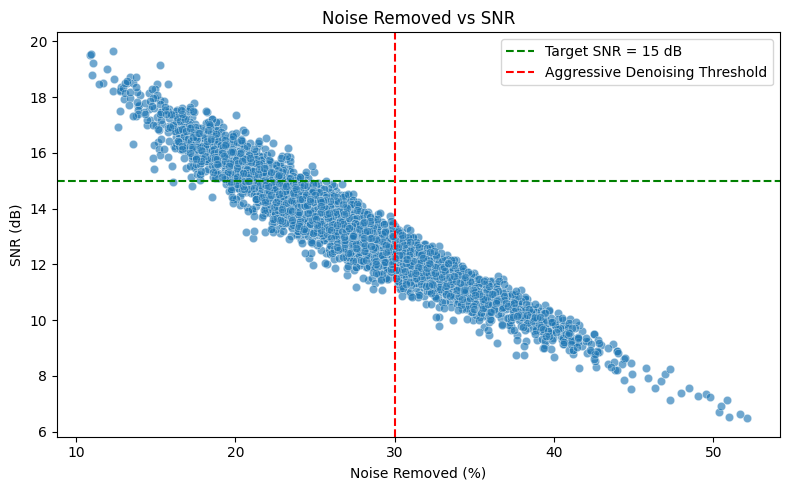

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.scatterplot(x=metrics_df['noise_reduction_%'], y=metrics_df['snr_db'], alpha=0.4)
plt.axhline(15, color='green', linestyle='--', label='Target SNR = 15 dB')
plt.axvline(30, color='red', linestyle='--', label='Aggressive Denoising Threshold')
plt.xlabel("Noise Removed (%)")
plt.ylabel("SNR (dB)")
plt.title("Noise Removed vs SNR")
plt.legend()
plt.tight_layout()
plt.show()

In [56]:
for item in metrics_list:
    file_path = os.path.join(filtered_output_dir, item["filename"])
    sf.write(file_path, item["denoised_audio"], item["sr"])
print(f"\n✅ Saved {len(metrics_list)} denoised audio files to: {filtered_output_dir}")



✅ Saved 9990 denoised audio files to: C:\Users\hp\Desktop\Longitudinal_ data\cleaned_filtered_all


# for a moderate rate

In [65]:

# ✅ Step 1: Setup Paths
root_dir = r"C:\Users\hp\Desktop\Longitudinal_ data"
clean_output_dir = os.path.join(root_dir, "cleaned_all")
os.makedirs(clean_output_dir, exist_ok=True)

# ✅ Step 2: Bandpass Filter Helper (Preserves human voice range)
def butter_bandpass_filter(data, sr, lowcut=300.0, highcut=3400.0, order=5):
    nyq = 0.5 * sr
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, data)

# ✅ Step 3: Collect .wav Files
all_wav_paths = []
for subdir, _, files in os.walk(root_dir):
    for file in files:
        if file.endswith('.wav'):
            all_wav_paths.append(os.path.join(subdir, file))

print(f"Found {len(all_wav_paths)} audio files.")

Found 4995 audio files.


In [66]:
# ✅ Step 4: Process & Store Metrics
metrics_list = []

for file_path in all_wav_paths:
    try:
        y, sr = librosa.load(file_path, sr=None)
        file_name = os.path.basename(file_path)

        # 🌀 Bandpass Filtering
        y_filtered = butter_bandpass_filter(y, sr)

        # 🤫 Moderate Noise Reduction (prop_decrease=0.5 to balance clarity)
        reduced = nr.reduce_noise(y=y_filtered, sr=sr, prop_decrease=0.5)

        # 🧮 Calculate Metrics
        duration = len(y) / sr
        noise = y_filtered - reduced
        mse = np.mean(noise ** 2)
        signal_energy = np.sum(y_filtered ** 2)
        snr = 10 * np.log10(np.sum(reduced ** 2) / (np.sum(noise ** 2) + 1e-8))
        noise_removed_percent = 100 * (np.sum(np.abs(noise)) / np.sum(np.abs(y_filtered)))

        # 🗂 Store metrics only (not saving audio yet)
        metrics_list.append({
            "filename": file_name,
            "duration_sec": round(duration, 2),
            "snr_db": round(snr, 2),
            "mse_distortion": round(mse, 8),
            "signal_energy": round(signal_energy, 2),
            "noise_removed_percent": round(noise_removed_percent, 2),
            "y_filtered": y_filtered,
            "reduced": reduced,
            "sr": sr
        })

    except Exception as e:
        print(f"Error processing {file_path}: {e}")


In [67]:

# ✅ Step 5: Convert to DataFrame and Print Summary
df_metrics = pd.DataFrame(metrics_list)
df_metrics_summary = df_metrics.drop(columns=["y_filtered", "reduced", "sr"])
print("\n📊 Denoising Metrics Summary:")
print(df_metrics_summary.describe())

print("\n📄 Sample of Recorded Metrics:")
print(df_metrics_summary[['filename', 'duration_sec', 'snr_db', 'mse_distortion', 'noise_removed_percent']].head(10))



📊 Denoising Metrics Summary:
       duration_sec       snr_db  mse_distortion  signal_energy  \
count   4995.000000  4995.000000    4.995000e+03    4995.000000   
mean       0.499499    19.206601    5.085180e-05      99.866625   
std        0.006923     1.683098    5.633843e-05      83.609140   
min        0.370000    13.110000    1.400000e-07       0.300000   
25%        0.500000    18.130000    1.406000e-05      31.125000   
50%        0.500000    19.250000    3.722000e-05      85.000000   
75%        0.500000    20.340000    6.792500e-05     146.765000   
max        0.500000    25.020000    1.232830e-03     878.510000   

       noise_removed_percent  
count            4995.000000  
mean               10.929171  
std                 1.901403  
min                 5.760000  
25%                 9.600000  
50%                10.880000  
75%                12.140000  
max                19.390000  

📄 Sample of Recorded Metrics:
                        filename  duration_sec  snr_db  

In [76]:
df_metrics.head()

,filename,duration_sec,snr_db,mse_distortion,signal_energy,noise_removed_percent,y_filtered,reduced,sr
0,1637846161578-recording-1.wav,0.5,15.45,3.780000e-06,3.86,15.17,"[-2.3418932747538614e-06, -2.1626754708142714e...","[4.6413704878426214e-05, 1.0251624439380524e-0...",44100
1,1637846163058-recording-1.wav,0.5,21.93,2.636000e-05,102.57,7.61,"[1.0483565562075048e-06, 9.663435769390386e-06...","[5.241788513519973e-07, 4.8317167554708425e-06...",44100
2,1637846854303-recording-1.wav,0.5,22.59,7.600000e-07,3.31,6.66,"[5.072693013907281e-08, 4.979944872850542e-07,...","[2.536346507382303e-08, 2.489972436444406e-07,...",44100
3,1637846855223-recording-1.wav,0.5,20.99,5.020000e-06,15.83,7.76,"[3.9736095275607036e-07, 3.886866003138738e-06...","[1.986804770649957e-07, 1.9434330022898496e-06...",44100
4,1637846856303-recording-1.wav,0.5,24.36,3.220000e-06,20.78,6.29,"[-9.299937192163349e-08, -8.819901027153882e-0...","[-4.6499685965426046e-08, -4.4099505136248826e...",44100


In [78]:
df_metrics['duration_sec'].value_counts()

duration_sec
0.50    4965
0.41      18
0.37       5
0.45       4
0.49       3
Name: count, dtype: int64

In [72]:
#saving the clean files

In [73]:
# ✅ Step 6: Save cleaned files using "_modclean.wav" suffix
save_dir = os.path.join(clean_output_dir, "modclean")
os.makedirs(save_dir, exist_ok=True)

for row in df_metrics.itertuples():
    new_filename = row.filename.replace(".wav", "_modclean.wav")
    save_path = os.path.join(save_dir, new_filename)
    sf.write(save_path, row.reduced, row.sr)

print(f"\n✅ Saved cleaned files to: {save_dir}")


✅ Saved cleaned files to: C:\Users\hp\Desktop\Longitudinal_ data\cleaned_all\modclean


C:\Users\hp\AppData\Local\Temp\ipykernel_26472\73657055.py:12: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\hp\AppData\Local\Temp\ipykernel_26472\73657055.py:14: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(plot_path)


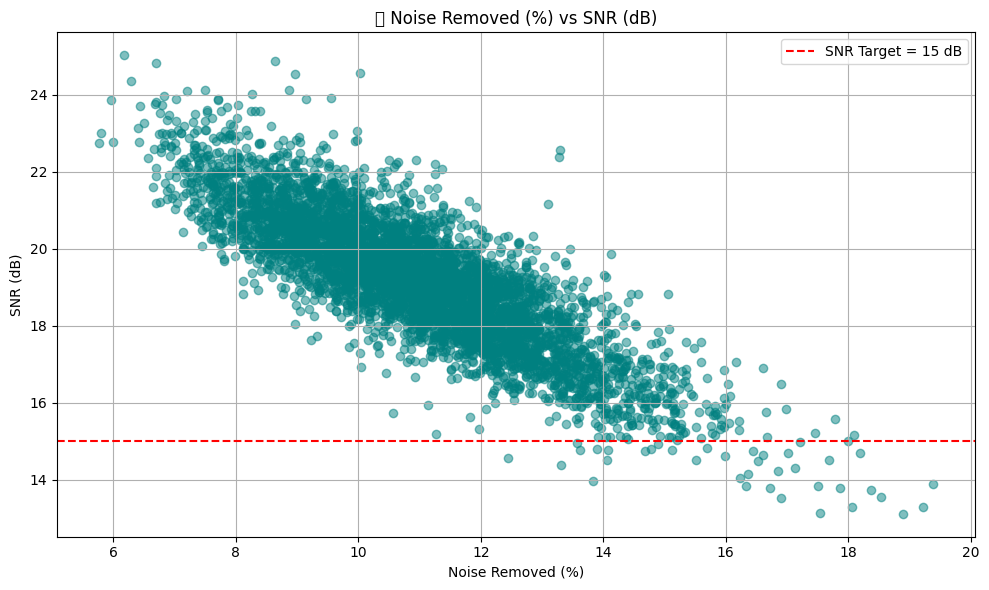


 Plot saved to: C:\Users\hp\Desktop\Longitudinal_ data\plots\noise_vs_snr_plot.png


In [75]:
plot_dir = os.path.join(root_dir, "plots")
os.makedirs(plot_dir, exist_ok=True)

plt.figure(figsize=(10, 6))
plt.scatter(df_metrics['noise_removed_percent'], df_metrics['snr_db'], alpha=0.5, color='teal')
plt.axhline(y=15, color='red', linestyle='--', label='SNR Target = 15 dB')
plt.xlabel("Noise Removed (%)")
plt.ylabel("SNR (dB)")
plt.title("📈 Noise Removed (%) vs SNR (dB)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plot_path = os.path.join(plot_dir, "noise_vs_snr_plot.png")
plt.savefig(plot_path)
plt.show()
print(f"\n Plot saved to: {plot_path}")

# Cough Segmentation

In [83]:
#  Path to your cleaned cough audio files
cleaned_output_direc = r"C:\Users\hp\Desktop\modclean"

# Create a folder to save segmented results (for Method A)
segment_dir_A = os.path.join(cleaned_output_direc, "segments_energy_based")
os.makedirs(segment_dir_A, exist_ok=True)

# 🧾 A list to keep track of all segments and their properties
segment_metrics_A = []

In [101]:
cleaned_output_direc = r"C:\Users\hp\Desktop\modclean"
files = os.listdir(cleaned_output_direc)
print(files)

['1637846161578-recording-1_modclean.wav', '1637846163058-recording-1_modclean.wav', '1637846854303-recording-1_modclean.wav', '1637846855223-recording-1_modclean.wav', '1637846856303-recording-1_modclean.wav', '1637846880764-recording-1_modclean.wav', '1637846881884-recording-1_modclean.wav', '1637846883124-recording-1_modclean.wav', '1637846884324-recording-1_modclean.wav', '1637846915833-recording-1_modclean.wav', '1637846916873-recording-1_modclean.wav', '1637846918033-recording-1_modclean.wav', '1637846919513-recording-1_modclean.wav', '1637846920913-recording-1_modclean.wav', '1637846922193-recording-1_modclean.wav', '1637846928393-recording-1_modclean.wav', '1637846956989-recording-1_modclean.wav', '1637846958109-recording-1_modclean.wav', '1637847619723-recording-1_modclean.wav', '1637847620883-recording-1_modclean.wav', '1637847652882-recording-1_modclean.wav', '1638029086609-recording-1_modclean.wav', '1639730762978-recording-1_modclean.wav', '1639731118302-recording-1_modcle

# define segmentation function: Energy based segmentation

In [102]:
def extract_segments_energy(y, sr, 
                            threshold_ratio=0.001,   
                            min_len_sec=0.1,           
                            silence_gap_sec=0.15,      
                            energy_thresh_db=-60):     

    energy = np.square(y)
    threshold = threshold_ratio * np.max(energy)
    indices = np.where(energy > threshold)[0]

    if len(indices) == 0:
        return []

    segments = []
    start = indices[0]
    

    for i in range(1, len(indices)):
        if indices[i] - indices[i - 1] > int(sr * silence_gap_sec):
            end = indices[i - 1]
            segment = y[start:end]
            duration = (end - start) / sr
            rms = np.sqrt(np.mean(segment**2))
            db = 20 * np.log10(rms + 1e-6)

            if duration >= min_len_sec and db > energy_thresh_db:
                segments.append((start, end))
            start = indices[i]

    # Final segment
    end = indices[-1]
    segment = y[start:end]
    duration = (end - start) / sr
    rms = np.sqrt(np.mean(segment**2))
    db = 20 * np.log10(rms + 1e-6)

    if duration >= min_len_sec and db > energy_thresh_db:
        segments.append((start, end))

    return segments

In [103]:
seg_counter_A = 0

for file in os.listdir(cleaned_output_direc):
    if not file.endswith(".wav"):
        continue

    try:
        file_path = os.path.join(cleaned_output_direc, file)
        y, sr = librosa.load(file_path, sr=None)

        segments = extract_segments_energy(y, sr)

        for i, (start, end) in enumerate(segments):
            segment = y[start:end]
            seg_name = f"{file.replace('.wav', '')}_A_seg{i}.wav"
            seg_path = os.path.join(segment_dir_A, seg_name)
            sf.write(seg_path, segment, sr)
            seg_counter_A += 1

            segment_metrics_A.append({
                "method": "energy_based",
                "original_file": file,
                "segment_name": seg_name,
                "duration_sec": round((end - start) / sr, 2),
                "start_sec": round(start / sr, 2),
                "end_sec": round(end / sr, 2)
            })

    except Exception as e:
        print(f"❌ Error processing {file}: {e}")

print(f"\n✅ Energy-Based Segmentation - Segments Saved: {seg_counter_A}")


✅ Energy-Based Segmentation - Segments Saved: 4994


# Section B Librosa - effect.split method

In [104]:
# here we would like t detect non silent parts of the audio based on DB (decibles) levels

In [105]:
# 📁 Input: Your cleaned audio folder
cleaned_output_direc = r"C:\Users\hp\Desktop\modclean"

# 📁 Output for this method (B)
segment_dir_B = os.path.join(cleaned_output_direc, "segments_librosa_split")
os.makedirs(segment_dir_B, exist_ok=True)

# 🧾 Where we’ll store info about each segment
segment_metrics_B = []

In [106]:
#defining the splitting function

In [107]:
def extract_segments_librosa_split(y, sr, top_db=35, min_len_sec=0.25):
    intervals = librosa.effects.split(y, top_db=top_db)  # Detect active (non-silent) regions
    segments = []

    for start, end in intervals:
        duration = (end - start) / sr
        if duration >= min_len_sec:
            segments.append((start, end))

    return segments

In [108]:
seg_counter_B = 0  # Count total segments

for file in os.listdir(cleaned_output_direc):
    if not file.endswith(".wav"):
        continue

    try:
        file_path = os.path.join(cleaned_output_direc, file)
        y, sr = librosa.load(file_path, sr=None)

        segments = extract_segments_librosa_split(y, sr)

        for i, (start, end) in enumerate(segments):
            segment = y[start:end]
            seg_name = f"{file.replace('.wav', '')}_B_seg{i}.wav"
            seg_path = os.path.join(segment_dir_B, seg_name)

            sf.write(seg_path, segment, sr)
            seg_counter_B += 1

            segment_metrics_B.append({
                "method": "librosa_split",
                "original_file": file,
                "segment_name": seg_name,
                "duration_sec": round((end - start) / sr, 2),
                "start_sec": round(start / sr, 2),
                "end_sec": round(end / sr, 2)
            })

    except Exception as e:
        print(f"❌ Error processing {file}: {e}")

print(f"\n✅ librosa.effects.split Segmentation - Segments Saved: {seg_counter_B}")


✅ librosa.effects.split Segmentation - Segments Saved: 4913


In [109]:
# Convert to DataFrame
seg_df_B = pd.DataFrame(segment_metrics_B)

# Summary
print("\n📊 librosa.effects.split Segmentation Summary:")
print(seg_df_B.describe())

# Sample
print("\n📄 Sample Segments:")
print(seg_df_B.head(10))


📊 librosa.effects.split Segmentation Summary:
       duration_sec    start_sec      end_sec
count   4913.000000  4913.000000  4913.000000
mean       0.429281     0.055141     0.484203
std        0.074028     0.063295     0.034254
min        0.260000     0.000000     0.260000
25%        0.360000     0.000000     0.500000
50%        0.450000     0.000000     0.500000
75%        0.500000     0.130000     0.500000
max        0.500000     0.230000     0.500000

📄 Sample Segments:
          method                           original_file  \
0  librosa_split  1637846161578-recording-1_modclean.wav   
1  librosa_split  1637846163058-recording-1_modclean.wav   
2  librosa_split  1637846854303-recording-1_modclean.wav   
3  librosa_split  1637846855223-recording-1_modclean.wav   
4  librosa_split  1637846856303-recording-1_modclean.wav   
5  librosa_split  1637846880764-recording-1_modclean.wav   
6  librosa_split  1637846881884-recording-1_modclean.wav   
7  librosa_split  1637846883124-recordi

In [110]:
# Save for future comparison
seg_df_B.to_csv(os.path.join(segment_dir_B, "segmentation_librosa_metrics.csv"), index=False)

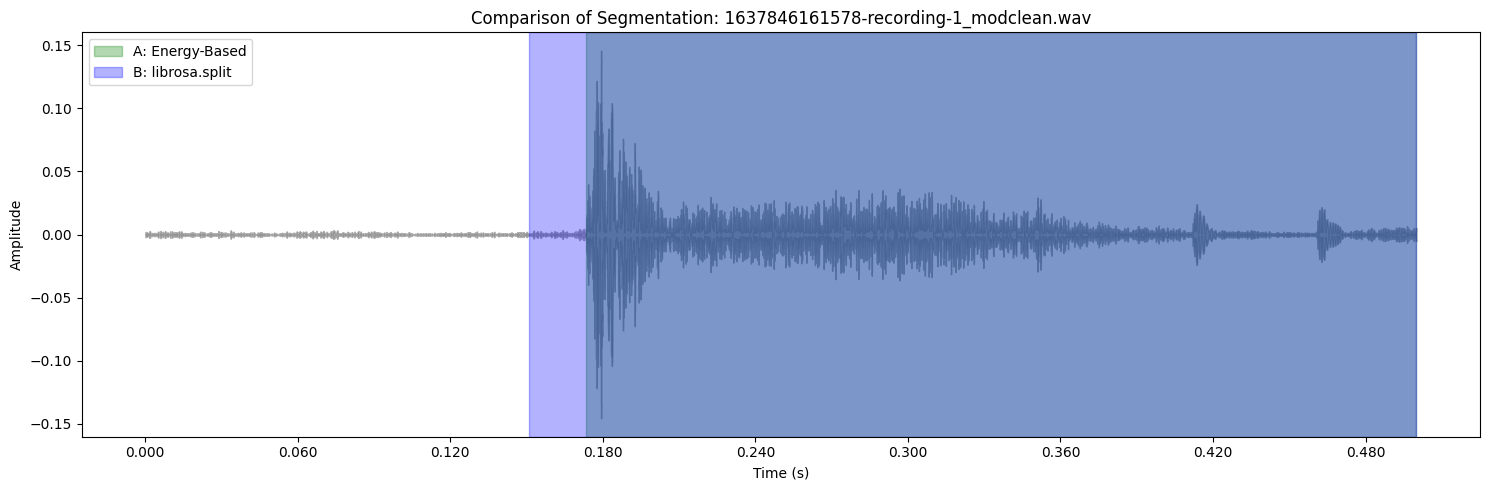

In [111]:
import librosa.display
import matplotlib.pyplot as plt

# 🔍 Choose a file you know exists
sample_file = "1637846161578-recording-1_modclean.wav"
file_path = os.path.join(cleaned_output_direc, sample_file)

# Load the audio
y, sr = librosa.load(file_path, sr=None)
duration = len(y) / sr
# A Segments (Energy-Based)
segments_A = extract_segments_energy(y, sr)

# B Segments (librosa.effects.split)
non_silent_intervals = librosa.effects.split(y, top_db=30)
segments_B = [(start, end) for start, end in non_silent_intervals if (end - start) / sr >= 0.25]

# Plot waveform
plt.figure(figsize=(15, 5))
librosa.display.waveshow(y, sr=sr, alpha=0.6, color='gray')
plt.title(f"Comparison of Segmentation: {sample_file}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

# Plot A method segments
for start, end in segments_A:
    plt.axvspan(start / sr, end / sr, color='green', alpha=0.3, label='A: Energy-Based')

#  Plot B method segments
for start, end in segments_B:
    plt.axvspan(start / sr, end / sr, color='blue', alpha=0.3, label='B: librosa.split')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()

# Hybrid Voting Segmentation

In [113]:
import pandas as pd

# Save the segment metrics list to a DataFrame (if not already done)
seg_df_A = pd.DataFrame(segment_metrics_A)

# Define the path where you want to save it
csv_path_A = r"C:\Users\hp\Desktop\segment A (Energy based)\segments_energy_based\segmentation_energy_metrics.csv"

# Save as CSV
seg_df_A.to_csv(csv_path_A, index=False)

print(f"✅ CSV saved successfully at:\n{csv_path_A}")


✅ CSV saved successfully at:
C:\Users\hp\Desktop\segment A (Energy based)\segments_energy_based\segmentation_energy_metrics.csv


In [114]:
seg_df_B = pd.DataFrame(segment_metrics_B)

csv_path_B = r"C:\Users\hp\Desktop\segments_librosa_split (Section B)\segmentation_librosa_metrics.csv"

seg_df_B.to_csv(csv_path_B, index=False)

print(f"✅ CSV saved successfully at:\n{csv_path_B}")


✅ CSV saved successfully at:
C:\Users\hp\Desktop\segments_librosa_split (Section B)\segmentation_librosa_metrics.csv


In [115]:
# Paths
segment_dir_A = r"C:\Users\hp\Desktop\segment A (Energy based)\segments_energy_based"
segment_dir_B = r"C:\Users\hp\Desktop\segments_librosa_split (Section B)"

csv_A = os.path.join(segment_dir_A, "segmentation_energy_metrics.csv")
csv_B = os.path.join(segment_dir_B, "segmentation_librosa_metrics.csv")

# 📥 Load CSVs
seg_df_A = pd.read_csv(csv_A)
seg_df_B = pd.read_csv(csv_B)

print("Metrics loaded successfully.")

Metrics loaded successfully.


In [117]:
# Pick a sample file (change to any valid filename in your dataset)
sample_file = "1637846161578-recording-1_modclean.wav"

# Filter segments from both methods for this file
segments_A = seg_df_A[seg_df_A["original_file"] == sample_file]
segments_B = seg_df_B[seg_df_B["original_file"] == sample_file]

# Loading the original audio
audio_path = os.path.join(r"C:\Users\hp\Desktop\modclean", sample_file)
y, sr = librosa.load(audio_path, sr=None)

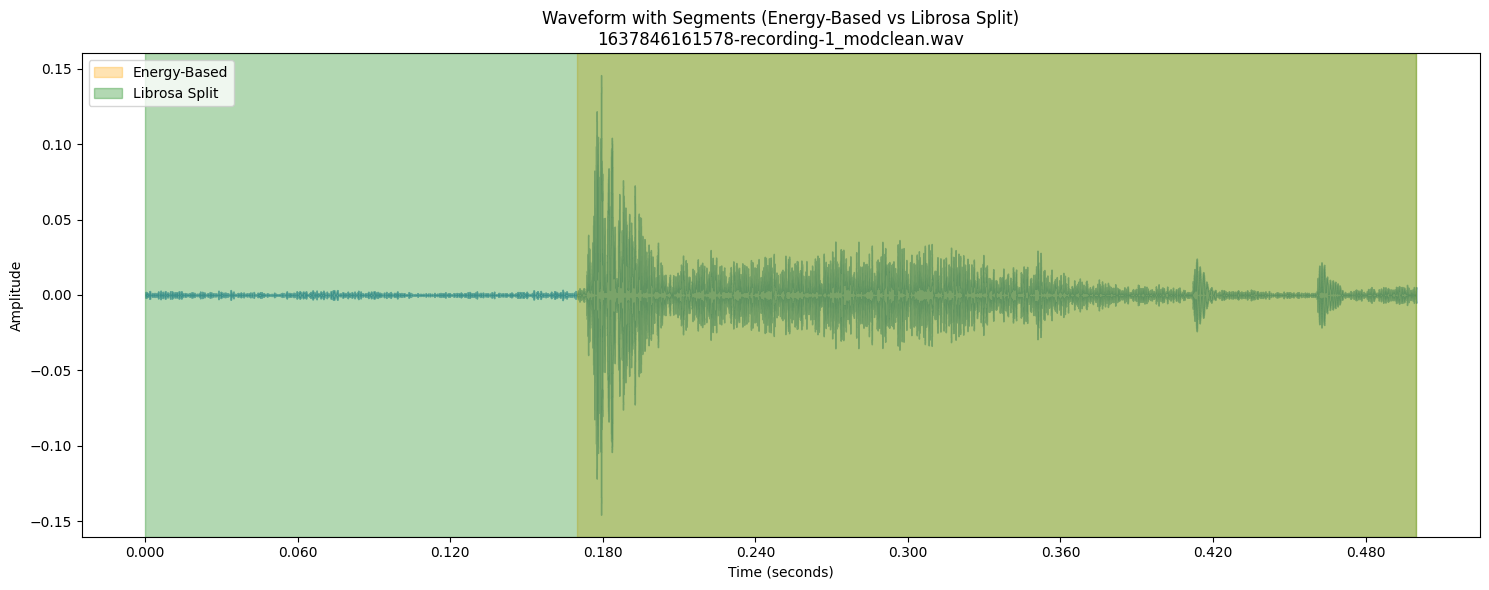

In [118]:
plt.figure(figsize=(15, 6))

# Plot waveform
librosa.display.waveshow(y, sr=sr, alpha=0.5)
plt.title(f"Waveform with Segments (Energy-Based vs Librosa Split)\n{sample_file}")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")

# Plot energy-based segments (Section A)
for _, row in segments_A.iterrows():
    plt.axvspan(row["start_sec"], row["end_sec"], color='orange', alpha=0.3, label="Energy-Based")

# Plot librosa.split segments (Section B)
for _, row in segments_B.iterrows():
    plt.axvspan(row["start_sec"], row["end_sec"], color='green', alpha=0.3, label="Librosa Split")


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()


In [116]:
print(seg_df_A.describe().T)
print(seg_df_B.describe().T)

               count      mean       std   min   25%   50%   75%   max
duration_sec  4994.0  0.402475  0.088788  0.11  0.34  0.41  0.50  0.50
start_sec     4994.0  0.064301  0.069981  0.00  0.00  0.02  0.14  0.37
end_sec       4994.0  0.466968  0.051005  0.21  0.44  0.50  0.50  0.50
               count      mean       std   min   25%   50%   75%   max
duration_sec  4913.0  0.429281  0.074028  0.26  0.36  0.45  0.50  0.50
start_sec     4913.0  0.055141  0.063295  0.00  0.00  0.00  0.13  0.23
end_sec       4913.0  0.484203  0.034254  0.26  0.50  0.50  0.50  0.50


In [122]:
# combine segments and remove duplicates

In [124]:
# 🔧 Directory paths
segment_dir_A = r"C:\Users\hp\Desktop\segment A (Energy based)\segments_energy_based"
segment_dir_B = r"C:\Users\hp\Desktop\segments_librosa_split (Section B)"
segment_dir_C = r"C:\Users\hp\Desktop\segments_hybrid"  # 🆕 For storing merged files

# Create hybrid directory if it doesn't exist
os.makedirs(segment_dir_C, exist_ok=True)

# 📥 Load segment metadata CSVs
seg_df_A = pd.read_csv(os.path.join(segment_dir_A, "segmentation_energy_metrics.csv"))
seg_df_B = pd.read_csv(os.path.join(segment_dir_B, "segmentation_librosa_metrics.csv"))

print(" Segment metrics from A and B loaded.")

 Segment metrics from A and B loaded.


In [125]:
# ➕ Add a source label for traceability
seg_df_A["source"] = "A"
seg_df_B["source"] = "B"

# 🔀 Combine both
combined_df = pd.concat([seg_df_A, seg_df_B], ignore_index=True)

# 🧹 Round start and end times to 2 decimal places to help detect duplicates
combined_df["start_sec"] = combined_df["start_sec"].round(2)
combined_df["end_sec"] = combined_df["end_sec"].round(2)

# 🔁 Remove duplicate segments (same file, start, and end times)
hybrid_df = combined_df.drop_duplicates(subset=["original_file", "start_sec", "end_sec"])

# ✅ Sort by filename and start time for orderliness
hybrid_df = hybrid_df.sort_values(by=["original_file", "start_sec"]).reset_index(drop=True)


In [126]:
# 💾 Save hybrid metadata CSV
hybrid_csv = os.path.join(segment_dir_C, "segmentation_hybrid_metrics.csv")
hybrid_df.to_csv(hybrid_csv, index=False)

print(f"\n Hybrid segmentation complete. Total unique segments: {len(hybrid_df)}")


 Hybrid segmentation complete. Total unique segments: 8738


In [127]:
import shutil 

In [128]:
saved = 0

for _, row in hybrid_df.iterrows():
    segment_name = row["segment_name"]
    src_dir = segment_dir_A if row["source"] == "A" else segment_dir_B
    src_path = os.path.join(src_dir, segment_name)
    dst_path = os.path.join(segment_dir_C, segment_name)

    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)
        saved += 1

print(f" Segment files copied to hybrid folder: {saved}")

 Segment files copied to hybrid folder: 8738


In [129]:
# Reload the saved hybrid metadata (to be sure)
hybrid_df = pd.read_csv(hybrid_csv)

# Describe duration, start, and end times
print("\n Hybrid Segmentation Summary:")
print(hybrid_df[["duration_sec", "start_sec", "end_sec"]].describe())

# Source distribution
print("\n Segment Count by Source (A vs B):")
print(hybrid_df["source"].value_counts())




 Hybrid Segmentation Summary:
       duration_sec    start_sec      end_sec
count   8738.000000  8738.000000  8738.000000
mean       0.404562     0.067748     0.472296
std        0.081972     0.067332     0.046228
min        0.110000     0.000000     0.210000
25%        0.350000     0.000000     0.450000
50%        0.400000     0.050000     0.500000
75%        0.490000     0.140000     0.500000
max        0.500000     0.370000     0.500000

 Segment Count by Source (A vs B):
source
A    4994
B    3744
Name: count, dtype: int64


In [131]:
# Show first few entries
print("\n Sample Segments:")
print(hybrid_df.head(10))


 Sample Segments:
          method                           original_file  \
0  librosa_split  1637846161578-recording-1_modclean.wav   
1   energy_based  1637846161578-recording-1_modclean.wav   
2  librosa_split  1637846163058-recording-1_modclean.wav   
3   energy_based  1637846163058-recording-1_modclean.wav   
4  librosa_split  1637846854303-recording-1_modclean.wav   
5   energy_based  1637846854303-recording-1_modclean.wav   
6  librosa_split  1637846855223-recording-1_modclean.wav   
7   energy_based  1637846855223-recording-1_modclean.wav   
8  librosa_split  1637846856303-recording-1_modclean.wav   
9   energy_based  1637846856303-recording-1_modclean.wav   

                                    segment_name  duration_sec  start_sec  \
0  1637846161578-recording-1_modclean_B_seg0.wav          0.50       0.00   
1  1637846161578-recording-1_modclean_A_seg0.wav          0.33       0.17   
2  1637846163058-recording-1_modclean_B_seg0.wav          0.38       0.12   
3  163784616

# filter by duration

In [132]:
# 📁Paths
hybrid_dir = r"C:\Users\hp\Desktop\segments_hybrid"
filtered_dir = r"C:\Users\hp\Desktop\segments_filtered_ml"

# ✅ Make sure destination folder exists
os.makedirs(filtered_dir, exist_ok=True)

In [133]:
# 📄 Load hybrid metadata
hybrid_csv = os.path.join(hybrid_dir, "segmentation_hybrid_metrics.csv")
hybrid_df = pd.read_csv(hybrid_csv)

# 🧽 Filter: keep segments between 0.3s and 0.5s
filtered_df = hybrid_df[
    (hybrid_df["duration_sec"] >= 0.3) &
    (hybrid_df["duration_sec"] <= 0.5)
].reset_index(drop=True)

print("Filtered segments count:", len(filtered_df))

Filtered segments count: 7861


In [134]:
copied = 0

for _, row in filtered_df.iterrows():
    src_path = os.path.join(hybrid_dir, row["segment_name"])
    dst_path = os.path.join(filtered_dir, row["segment_name"])

    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)
        copied += 1

print(f"Segment files copied to filtered folder: {copied}")

Segment files copied to filtered folder: 7861


In [135]:
# 📄 Save filtered metadata
filtered_csv = os.path.join(filtered_dir, "segmentation_filtered_metrics.csv")
filtered_df.to_csv(filtered_csv, index=False)

print("Filtered CSV saved successfully at:", filtered_csv)

Filtered CSV saved successfully at: C:\Users\hp\Desktop\segments_filtered_ml\segmentation_filtered_metrics.csv


In [136]:
print("filtered segment metrics summary:")
print(filtered_df.describe())

filtered segment metrics summary:
       duration_sec    start_sec      end_sec
count   7861.000000  7861.000000  7861.000000
mean       0.420963     0.059461     0.480474
std        0.068437     0.065007     0.039046
min        0.300000     0.000000     0.300000
25%        0.360000     0.000000     0.480000
50%        0.420000     0.020000     0.500000
75%        0.500000     0.130000     0.500000
max        0.500000     0.200000     0.500000


In [137]:
#checking the segment count

In [138]:
print("\n segment count by source:")
print(filtered_df['source'].value_counts())


 segment count by source:
source
A    4351
B    3510
Name: count, dtype: int64


#observations

- the total segments we have here is 7861 which is strong enough size for machine learning model training and the mean duration is 0.4209 secs which is ideal for cough analysis
- two methods were mixed which is the enegy based level and the librosa split effect; this was done to avoid bias, and capture  coughs different acoustic condition

# feature extraction

In [139]:

# 📁 Set paths
filtered_dir = r"C:\Users\hp\Desktop\segments_filtered_ml"
metadata_csv = os.path.join(filtered_dir, "segmentation_filtered_metrics.csv")
output_csv = os.path.join(filtered_dir, "features_extracted.csv")

# 📄 Load metadata
metadata = pd.read_csv(metadata_csv)

# 🧠 Define feature extraction function
def extract_features(audio_path):
    try:
        y, sr = librosa.load(audio_path, sr=None)

        # Duration
        duration = librosa.get_duration(y=y, sr=sr)

        # Zero-crossing rate
        zcr = np.mean(librosa.feature.zero_crossing_rate(y=y))

        # RMS energy
        rms = np.mean(librosa.feature.rms(y=y))

        # MFCCs (first 13)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)

        # Spectral Centroid
        centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))

        # Spectral Bandwidth
        bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))

        # Chroma
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)

        # Combine features
        features = {
            "duration": duration,
            "zcr": zcr,
            "rms": rms,
            "centroid": centroid,
            "bandwidth": bandwidth,
        }

        # Add MFCCs
        for i, coef in enumerate(mfcc_mean):
            features[f"mfcc{i+1}"] = coef

        # Add Chroma
        for i, c in enumerate(chroma_mean):
            features[f"chroma{i+1}"] = c

        return features
    except:
        return None

In [141]:
from tqdm import tqdm
# 🛠️ Run feature extraction
feature_list = []

print(" Extracting features...")

for _, row in tqdm(metadata.iterrows(), total=len(metadata)):
    segment_name = row["segment_name"]
    audio_path = os.path.join(filtered_dir, segment_name)
    features = extract_features(audio_path)

    if features:
        features["segment_name"] = segment_name
        features["source"] = row["source"]
        feature_list.append(features)

#  Convert to DataFrame and save
features_df = pd.DataFrame(feature_list)
features_df.to_csv(output_csv, index=False)

print(f"\nFeatures extracted and saved to: {output_csv}")

 Extracting features...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7861/7861 [08:16<00:00, 15.84it/s]



Features extracted and saved to: C:\Users\hp\Desktop\segments_filtered_ml\features_extracted.csv


In [142]:
df3 = pd.read_csv("features_extracted.csv")

In [143]:
df3.head()

,duration,zcr,rms,centroid,bandwidth,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,...,chroma5,chroma6,chroma7,chroma8,chroma9,chroma10,chroma11,chroma12,segment_name,source
0,0.500000,0.052446,0.007839,1705.614801,1816.147583,-516.54480,181.83930,-63.653220,-25.869099,12.373714,...,0.430567,0.398017,0.384999,0.373229,0.390209,0.452779,0.560157,0.598327,1637846161578-recording-1_modclean_B_seg0.wav,B
1,0.326395,0.056051,0.010528,1773.697440,1676.863591,-468.75677,196.16843,-81.812035,-17.464970,17.987204,...,0.453084,0.426920,0.384567,0.409067,0.447523,0.497901,0.534006,0.572999,1637846161578-recording-1_modclean_A_seg0.wav,A
2,0.383900,0.069508,0.068351,1876.079818,1292.192779,-278.28745,225.06860,-125.673110,-14.574010,11.169606,...,0.460135,0.609525,0.678125,0.740859,0.523680,0.386552,0.453093,0.606863,1637846163058-recording-1_modclean_B_seg0.wav,B
3,0.370385,0.070633,0.071439,1887.887451,1339.100746,-265.71143,226.25464,-127.472470,-14.709650,10.480814,...,0.418230,0.583133,0.683762,0.766526,0.557250,0.401180,0.446168,0.611722,1637846163058-recording-1_modclean_A_seg0.wav,A
4,0.336689,0.078613,0.011354,2023.489043,1540.129863,-492.66500,205.74506,-116.564430,-28.175056,23.687134,...,0.516194,0.339251,0.385797,0.431193,0.403176,0.321973,0.350135,0.459504,1637846854303-recording-1_modclean_B_seg0.wav,B


In [148]:
#df3.isnull().sum()

In [151]:
df3.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,7861.0,0.420813,0.068153,0.295170,0.359909,0.418345,0.497234,0.500000
zcr,7861.0,0.056866,0.012911,0.019738,0.048245,0.056434,0.064811,0.152233
rms,7861.0,0.051637,0.026179,0.003167,0.030101,0.050797,0.069746,0.159923
centroid,7861.0,1647.493883,236.462747,835.176994,1501.129294,1646.038632,1794.831998,3571.651203
bandwidth,7861.0,1357.530649,166.465995,825.714825,1248.039886,1340.451961,1450.518090,2543.632286
mfcc1,7861.0,-368.729731,63.822503,-597.474700,-408.376600,-357.966980,-321.993700,-230.881590
mfcc2,7861.0,199.288871,18.335952,117.400800,187.398100,199.478640,211.661800,263.070770
mfcc3,7861.0,-82.100620,24.787252,-171.018000,-98.945496,-82.771540,-66.801230,14.689302
mfcc4,7861.0,-41.683020,13.135841,-95.104744,-50.276188,-42.131640,-33.530600,52.958847
mfcc5,7861.0,8.302280,11.214723,-50.016750,1.190943,8.443407,15.478138,56.716618


In [144]:
df4 = pd.read_csv("segmentation_filtered_metrics.csv")

In [155]:
df4.head()

,method,original_file,segment_name,duration_sec,start_sec,end_sec,source
0,librosa_split,1637846161578-recording-1_modclean.wav,1637846161578-recording-1_modclean_B_seg0.wav,0.50,0.00,0.50,B
1,energy_based,1637846161578-recording-1_modclean.wav,1637846161578-recording-1_modclean_A_seg0.wav,0.33,0.17,0.50,A
2,librosa_split,1637846163058-recording-1_modclean.wav,1637846163058-recording-1_modclean_B_seg0.wav,0.38,0.12,0.50,B
3,energy_based,1637846163058-recording-1_modclean.wav,1637846163058-recording-1_modclean_A_seg0.wav,0.37,0.13,0.50,A
4,librosa_split,1637846854303-recording-1_modclean.wav,1637846854303-recording-1_modclean_B_seg0.wav,0.34,0.15,0.49,B


In [154]:
df4.describe().T

,count,mean,std,min,25%,50%,75%,max
duration_sec,7861.0,0.420963,0.068437,0.3,0.36,0.42,0.50,0.5
start_sec,7861.0,0.059461,0.065007,0.0,0.00,0.02,0.13,0.2
end_sec,7861.0,0.480474,0.039046,0.3,0.48,0.50,0.50,0.5


# getting the best cough sound from the segments

In [161]:
import librosa
import librosa.display
import gc  # for garbage collection

# Paths
audio_dir = r"C:\Users\hp\Desktop\segments_filtered_ml"
output_dir = r"C:\Users\hp\Desktop\mel_spectrograms"
os.makedirs(output_dir, exist_ok=True)

metadata = []

def save_mel_spectrogram(audio_path, output_path, sr=16000, n_mels=64):
    try:
        y, sr = librosa.load(audio_path, sr=sr, mono=True, duration=2.0)  # Mono & max 2s
        duration = librosa.get_duration(y=y, sr=sr)

        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=512, hop_length=256)
        S_DB = librosa.power_to_db(S, ref=np.max)

        # Save image with tight memory
        plt.figure(figsize=(2, 2), dpi=72)
        librosa.display.specshow(S_DB, sr=sr, x_axis=None, y_axis=None, cmap='magma')
        plt.axis('off')
        plt.tight_layout(pad=0)
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
        plt.close()
        plt.clf()
        gc.collect()  # Force memory cleanup

        return duration

    except Exception as e:
        print(f"❌ Error with {audio_path}: {e}")
        return None

# Loop through all files
for filename in os.listdir(audio_dir):
    if filename.endswith(".wav"):
        segment_name = filename
        audio_path = os.path.join(audio_dir, filename)
        output_img_name = filename.replace(".wav", ".png")
        output_img_path = os.path.join(output_dir, output_img_name)

        # Save spectrogram and get duration
        duration = save_mel_spectrogram(audio_path, output_img_path)

        if duration is None:
            continue  # Skip if failed

        # Extract source (A or B)
        source = "A" if "_A_" in filename else "B" if "_B_" in filename else "Unknown"

        # Save metadata entry
        metadata.append({
            "segment_name": segment_name,
            "spectrogram_image": output_img_name,
            "source": source,
            "duration_sec": duration
        })

# Save metadata as CSV
df_meta = pd.DataFrame(metadata)
csv_path = os.path.join(output_dir, "mel_spectrogram_metadata.csv")
df_meta.to_csv(csv_path, index=False)

print("All spectrograms and metadata saved to:", csv_path)


All spectrograms and metadata saved to: C:\Users\hp\Desktop\mel_spectrograms\mel_spectrogram_metadata.csv


In [166]:
import os
import shutil
import pandas as pd

# === STEP 0: Set paths ===
features_csv = r"C:\Users\hp\Desktop\features_ext\features_extracted.csv"  # ✅ FIX THIS PATH if needed
segments_audio_dir = r"C:\Users\hp\Desktop\segments_filtered_ml"
output_audio_dir = r"C:\Users\hp\Desktop\best_4996_segments"
os.makedirs(output_audio_dir, exist_ok=True)

# === STEP 1: Load and clean feature data ===
df = pd.read_csv(features_csv)

# Remove duplicates based on segment name
df.drop_duplicates(subset="segment_name", inplace=True)

# Create a base name from each segment, removing _A_ or _B_ to group by base audio
df["base_name"] = df["segment_name"].apply(
    lambda x: x.split("_modclean")[0] if "_modclean" in x else "_".join(x.split("_")[:2])
)

# Sort by RMS (or another good quality metric)
df_sorted = df.sort_values(by=["base_name", "rms"], ascending=[True, False])

# Group and pick the top one per base_name
best_df = df_sorted.groupby("base_name").head(1).reset_index(drop=True)

# Check final count
print("✅ Selected unique best segments:", len(best_df))

# === STEP 2: Copy the selected best audio files ===
copied = 0
for _, row in best_df.iterrows():
    segment_filename = row["segment_name"]
    if not segment_filename.endswith(".wav"):
        segment_filename += ".wav"

    src_path = os.path.join(segments_audio_dir, segment_filename)
    dst_path = os.path.join(output_audio_dir, segment_filename)

    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)
        copied += 1
    else:
        print(f"⚠️ File not found: {segment_filename}")

# === STEP 3: Final reporting ===
print(f"\n✅ Finished copying best {copied} segments to:\n{output_audio_dir}")


✅ Selected unique best segments: 4842

✅ Finished copying best 4842 segments to:
C:\Users\hp\Desktop\best_4996_segments


In [167]:
# Needed for librosa's power_to_db

# === STEP 0: Set paths ===
audio_dir = r"C:\Users\hp\Desktop\best_4996_segments"
output_image_dir = r"C:\Users\hp\Desktop\mel_spectrograms_4996"
os.makedirs(output_image_dir, exist_ok=True)

# === STEP 1: Loop through all .wav files and generate Mel spectrograms ===
for filename in os.listdir(audio_dir):
    if filename.endswith(".wav"):
        audio_path = os.path.join(audio_dir, filename)

        try:
            # Load audio file
            y, sr = librosa.load(audio_path, sr=None)

            # Compute Mel spectrogram
            S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
            S_DB = librosa.power_to_db(S, ref=np.max)

            # Create a figure
            plt.figure(figsize=(4, 3))
            librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
            plt.axis('off')  # Remove axes
            plt.tight_layout(pad=0)

            # Save the figure as .png
            output_image_path = os.path.join(output_image_dir, filename.replace(".wav", ".png"))
            plt.savefig(output_image_path, bbox_inches='tight', pad_inches=0)
            plt.close()

        except Exception as e:
            print(f"❌ Failed to process {filename}: {e}")

print("\n✅ Finished generating Mel spectrograms!")


✅ Finished generating Mel spectrograms!


In [168]:

def estimate_snr(y):
    """Estimate Signal-to-Noise Ratio (SNR) using harmonic-percussive separation."""
    try:
        harmonic, _ = librosa.effects.hpss(y)
        signal_power = np.mean(y ** 2)
        noise = y - harmonic
        noise_power = np.mean(noise ** 2)
        return 10 * np.log10(signal_power / (noise_power + 1e-10))
    except:
        return 0  # Fallback if separation fails

# Assuming y and sr are already defined:
rms = librosa.feature.rms(y=y).mean()
snr = estimate_snr(y)
zcr = librosa.feature.zero_crossing_rate(y).mean()
flatness = librosa.feature.spectral_flatness(y=y).mean()
duration = librosa.get_duration(y=y, sr=sr)

# Print metrics
print(f"RMS: {rms:.4f}")
print(f"SNR: {snr:.2f} dB")
print(f"Zero-Crossing Rate: {zcr:.4f}")
print(f"Spectral Flatness: {flatness:.4f}")
print(f"Duration: {duration:.2f} seconds")

RMS: 0.0730
SNR: 3.84 dB
Zero-Crossing Rate: 0.0700
Spectral Flatness: 0.0003
Duration: 0.37 seconds


# observations
- the audio is not silent (RMS is good), and it's tonal. However, the SNR, is too low and the duration is very short, which could reduce its usefulness.
- this clip may not be ideal for hih quality classification or training unless the model is built for very short segments

In [163]:
import os
import librosa
import librosa.display
import datetime

# 🎯 Paths
audio_dir = r"C:\Users\hp\Desktop\segments_filtered_ml"
output_dir = r"C:\Users\hp\Desktop\mel_spectrograms"
os.makedirs(output_dir, exist_ok=True)

metadata = []

# 🔁 Function to generate and save mel spectrogram
def save_mel_spectrogram(audio_path, output_path, sr=22050, n_mels=128):
    y, sr = librosa.load(audio_path, sr=sr)
    duration = librosa.get_duration(y=y, sr=sr)

    # Generate mel spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    S_DB = librosa.power_to_db(S, ref=np.max)

    # Save image
    plt.figure(figsize=(2.5, 2.5))
    librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel', cmap='magma')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()

    return duration

# 🔁 Loop through all .wav files and generate spectrograms
for filename in os.listdir(audio_dir):
    if filename.endswith(".wav"):
        segment_name = filename
        audio_path = os.path.join(audio_dir, filename)
        output_img_name = filename.replace(".wav", ".png")
        output_img_path = os.path.join(output_dir, output_img_name)

        try:
            # Generate and save spectrogram
            duration = save_mel_spectrogram(audio_path, output_img_path)

            # Infer source label
            source = "A" if "_A_" in filename else "B" if "_B_" in filename else "Unknown"

            # Save metadata row
            metadata.append({
                "segment_name": segment_name,
                "spectrogram_image": output_img_name,
                "source": source,
                "duration_sec": duration
            })
        
        except Exception as e:
            print(f"⚠️ Error processing {filename}: {e}")

# 💾 Save metadata with timestamp to avoid overwrite/lock issues
df_meta = pd.DataFrame(metadata)
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
csv_path = os.path.join(output_dir, f"mel_spectrogram_metadata_{timestamp}.csv")
df_meta.to_csv(csv_path, index=False)

print("✅ Metadata saved at:", csv_path)


✅ Metadata saved at: C:\Users\hp\Desktop\mel_spectrograms\mel_spectrogram_metadata_20250709_144141.csv


# Deep Feature Embeddings

In [156]:
# Paths
audio_dir = r"C:\Users\hp\Desktop\segments_filtered_ml"  # Where filtered .wav files are
output_dir = r"C:\Users\hp\Desktop\mel_spectrograms"     # Where to save spectrogram images
os.makedirs(output_dir, exist_ok=True)  # Create the folder if it doesn't exist

# Function to convert .wav audio into mel spectrogram image
def save_mel_spectrogram(audio_path, output_path, sr=22050, n_mels=128):
    y, sr = librosa.load(audio_path, sr=sr)  # Load audio
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)  # Generate mel spectrogram
    S_DB = librosa.power_to_db(S, ref=np.max)  # Convert to decibels (better for visuals)

    # Plot without axis, save as image
    plt.figure(figsize=(2.5, 2.5))
    librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel', cmap='magma')
    plt.axis('off')  # Hide axis ticks
    plt.tight_layout()
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()

# Apply to all audio files
for filename in os.listdir(audio_dir):
    if filename.endswith(".wav"):
        audio_path = os.path.join(audio_dir, filename)
        output_path = os.path.join(output_dir, filename.replace(".wav", ".png"))
        save_mel_spectrogram(audio_path, output_path)

print(" All mel spectrograms saved at:", output_dir)

 All mel spectrograms saved at: C:\Users\hp\Desktop\mel_spectrograms


- bright colors (yellow/orange) rep loud sounds are there
- dark colors (purple/black) = quiet or no sounds here
- Red/pink: medium loud sound

In [169]:
#best audio sounds extracted

In [170]:
import os
import librosa
import numpy as np
import shutil

# === STEP 0: Set paths ===
audio_dir = r"C:\Users\hp\Desktop\segments_filtered_ml"  # Input folder
output_dir = r"C:\Users\hp\Desktop\best_filtered_segments"  # Output for best audios
os.makedirs(output_dir, exist_ok=True)

# === STEP 1: SNR function ===
def estimate_snr(y):
    try:
        harmonic, _ = librosa.effects.hpss(y)
        signal_power = np.mean(y ** 2)
        noise = y - harmonic
        noise_power = np.mean(noise ** 2)
        return 10 * np.log10(signal_power / (noise_power + 1e-10))
    except:
        return 0

# === STEP 2: Filter and save best audios ===
for filename in os.listdir(audio_dir):
    if filename.endswith(".wav"):
        file_path = os.path.join(audio_dir, filename)
        try:
            y, sr = librosa.load(file_path, sr=None)

            # Compute metrics
            rms = librosa.feature.rms(y=y).mean()
            snr = estimate_snr(y)
            zcr = librosa.feature.zero_crossing_rate(y).mean()
            flatness = librosa.feature.spectral_flatness(y=y).mean()
            duration = librosa.get_duration(y=y, sr=sr)

            # Quality filtering
            if rms > 0.01 and snr > 10 and zcr < 0.2 and flatness < 0.5 and duration > 1.0:
                shutil.copy(file_path, os.path.join(output_dir, filename))

        except Exception as e:
            print(f"Error processing {filename}: {e}")

print(f"\n Finished. Best audios saved to: {output_dir}")


 Finished. Best audios saved to: C:\Users\hp\Desktop\best_filtered_segments


In [ ]:
import os
import librosa
import numpy as np
import shutil

# === STEP 0: Set paths ===
audio_dir = r"C:\Users\hp\Desktop\segments_filtered_ml"  # Input folder
output_dir = r"C:\Users\hp\Desktop\best_filtered_segments"  # Output for best audios
os.makedirs(output_dir, exist_ok=True)

# === STEP 1: SNR function ===
def estimate_snr(y):
    try:
        harmonic, _ = librosa.effects.hpss(y)
        signal_power = np.mean(y ** 2)
        noise = y - harmonic
        noise_power = np.mean(noise ** 2)
        return 10 * np.log10(signal_power / (noise_power + 1e-10))
    except:
        return 0

# === STEP 2: Filter and save best audios ===
print("\n🔍 Starting audio filtering...\n")
for filename in os.listdir(audio_dir):
    if filename.endswith(".wav"):
        file_path = os.path.join(audio_dir, filename)
        try:
            y, sr = librosa.load(file_path, sr=None)

            # Compute metrics
            rms = librosa.feature.rms(y=y).mean()
            snr = estimate_snr(y)
            zcr = librosa.feature.zero_crossing_rate(y).mean()
            flatness = librosa.feature.spectral_flatness(y=y).mean()
            duration = librosa.get_duration(y=y, sr=sr)

            # Show metrics for debugging
            print(f"🎧 {filename}")
            print(f"   RMS: {rms:.4f}, SNR: {snr:.2f} dB, ZCR: {zcr:.4f}, Flatness: {flatness:.4f}, Duration: {duration:.2f} sec")

            # Relaxed Quality Thresholds (adjust if needed)
            if rms > 0.005 and snr > 3 and zcr < 0.3 and flatness < 0.6 and duration > 0.3:
                shutil.copy(file_path, os.path.join(output_dir, filename))
                print("   ✅ Saved: Passed filter.\n")
            else:
                print("   ❌ Skipped: Did not meet thresholds.\n")

        except Exception as e:
            print(f" Error processing {filename}: {e}\n")

print(f"\nDone! Check your best audios here: {output_dir}")


🔍 Starting audio filtering...

🎧 1637846161578-recording-1_modclean_A_seg0.wav
   RMS: 0.0105, SNR: 2.93 dB, ZCR: 0.0561, Flatness: 0.0005, Duration: 0.33 sec
   ❌ Skipped: Did not meet thresholds.

🎧 1637846161578-recording-1_modclean_B_seg0.wav
   RMS: 0.0078, SNR: 1.50 dB, ZCR: 0.0524, Flatness: 0.0003, Duration: 0.50 sec
   ❌ Skipped: Did not meet thresholds.

🎧 1637846163058-recording-1_modclean_A_seg0.wav
   RMS: 0.0714, SNR: 5.14 dB, ZCR: 0.0706, Flatness: 0.0001, Duration: 0.37 sec
   ✅ Saved: Passed filter.

🎧 1637846163058-recording-1_modclean_B_seg0.wav
   RMS: 0.0684, SNR: 4.72 dB, ZCR: 0.0695, Flatness: 0.0000, Duration: 0.38 sec
   ✅ Saved: Passed filter.

🎧 1637846854303-recording-1_modclean_B_seg0.wav
   RMS: 0.0114, SNR: 5.06 dB, ZCR: 0.0786, Flatness: 0.0003, Duration: 0.34 sec
   ✅ Saved: Passed filter.

🎧 1637846855223-recording-1_modclean_A_seg0.wav
   RMS: 0.0260, SNR: 6.73 dB, ZCR: 0.0813, Flatness: 0.0011, Duration: 0.30 sec
   ✅ Saved: Passed filter.

🎧 163784

In [ ]:
#showing the passed spectrograms

In [173]:
# === STEP 0: Set paths ===
best_audio_dir = r"C:\Users\hp\Desktop\best_filtered_segments"  # From previous step
output_image_dir = r"C:\Users\hp\Desktop\mel_spectrograms_best"  # Where to save PNGs
os.makedirs(output_image_dir, exist_ok=True)

# === STEP 1: Generate and save Mel spectrograms ===
print("\n🖼 Generating Mel spectrograms...\n")

for filename in os.listdir(best_audio_dir):
    if filename.endswith(".wav"):
        audio_path = os.path.join(best_audio_dir, filename)
        output_path = os.path.join(output_image_dir, filename.replace(".wav", ".png"))

        try:
            # Load audio
            y, sr = librosa.load(audio_path, sr=None)

            # Compute Mel spectrogram
            S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
            S_DB = librosa.power_to_db(S, ref=np.max)

            # Plot and save image
            plt.figure(figsize=(3, 3))
            librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel', cmap='magma')
            plt.axis('off')  # Hide axes
            plt.tight_layout()
            plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
            plt.close()

            print(f"Saved: {output_path}")

        except Exception as e:
            print(f" Failed to process {filename}: {e}")

print(f"\n All Mel spectrograms saved to: {output_image_dir}")


🖼 Generating Mel spectrograms...

Saved: C:\Users\hp\Desktop\mel_spectrograms_best\1637846163058-recording-1_modclean_A_seg0.png
Saved: C:\Users\hp\Desktop\mel_spectrograms_best\1637846163058-recording-1_modclean_B_seg0.png
Saved: C:\Users\hp\Desktop\mel_spectrograms_best\1637846854303-recording-1_modclean_B_seg0.png
Saved: C:\Users\hp\Desktop\mel_spectrograms_best\1637846855223-recording-1_modclean_A_seg0.png
Saved: C:\Users\hp\Desktop\mel_spectrograms_best\1637846855223-recording-1_modclean_B_seg0.png
Saved: C:\Users\hp\Desktop\mel_spectrograms_best\1637846880764-recording-1_modclean_B_seg0.png
Saved: C:\Users\hp\Desktop\mel_spectrograms_best\1637846881884-recording-1_modclean_A_seg0.png
Saved: C:\Users\hp\Desktop\mel_spectrograms_best\1637846881884-recording-1_modclean_B_seg0.png
Saved: C:\Users\hp\Desktop\mel_spectrograms_best\1637846883124-recording-1_modclean_A_seg0.png
Saved: C:\Users\hp\Desktop\mel_spectrograms_best\1637846883124-recording-1_modclean_B_seg0.png
Saved: C:\Users

# saving the characteristics of only the best passed -cough

In [174]:
# === STEP 0: Define paths ===
audio_dir = r"C:\Users\hp\Desktop\best_filtered_segments"
output_csv = r"C:\Users\hp\Desktop\best_filtered_audio_characteristics.csv"

# === STEP 1: SNR estimation function ===
def estimate_snr(y):
    try:
        harmonic, _ = librosa.effects.hpss(y)
        signal_power = np.mean(y ** 2)
        noise = y - harmonic
        noise_power = np.mean(noise ** 2)
        return 10 * np.log10(signal_power / (noise_power + 1e-10))
    except:
        return 0


In [175]:
# === STEP 2: Extract characteristics from each filtered audio ===
metadata = []

print("\n Extracting characteristics from best filtered audios...\n")
for filename in os.listdir(audio_dir):
    if filename.endswith(".wav"):
        file_path = os.path.join(audio_dir, filename)
        try:
            y, sr = librosa.load(file_path, sr=None)

            duration = librosa.get_duration(y=y, sr=sr)
            rms = librosa.feature.rms(y=y).mean()
            zcr = librosa.feature.zero_crossing_rate(y=y).mean()
            flatness = librosa.feature.spectral_flatness(y=y).mean()
            snr = estimate_snr(y)

            metadata.append({
                "filename": filename,
                "duration_sec": round(duration, 4),
                "rms": round(rms, 6),
                "zcr": round(zcr, 6),
                "flatness": round(flatness, 6),
                "snr_db": round(snr, 2)
            })

        except Exception as e:
            print(f" Error processing {filename}: {e}")


 Extracting characteristics from best filtered audios...



In [176]:
# === STEP 3: Save to CSV ===
df_meta = pd.DataFrame(metadata)
df_meta.to_csv(output_csv, index=False)

print(f"\n✅ Characteristics saved to: {output_csv}")
print("🔢 Total audios processed:", len(df_meta))


✅ Characteristics saved to: C:\Users\hp\Desktop\best_filtered_audio_characteristics.csv
🔢 Total audios processed: 5189


In [ ]:
#getting the metrics 

In [171]:
import os
import librosa
import numpy as np

# === Set path to best audios ===
best_audio_dir = r"C:\Users\hp\Desktop\best_filtered_segments"

# === SNR function ===
def estimate_snr(y):
    try:
        harmonic, _ = librosa.effects.hpss(y)
        signal_power = np.mean(y ** 2)
        noise = y - harmonic
        noise_power = np.mean(noise ** 2)
        return 10 * np.log10(signal_power / (noise_power + 1e-10))
    except:
        return 0

# === Print metrics for each best audio ===
print(f"\n📊 Metrics for audios in: {best_audio_dir}\n")
for filename in os.listdir(best_audio_dir):
    if filename.endswith(".wav"):
        path = os.path.join(best_audio_dir, filename)
        try:
            y, sr = librosa.load(path, sr=None)

            rms = librosa.feature.rms(y=y).mean()
            snr = estimate_snr(y)
            zcr = librosa.feature.zero_crossing_rate(y).mean()
            flatness = librosa.feature.spectral_flatness(y=y).mean()
            duration = librosa.get_duration(y=y, sr=sr)

            print(f"🎧 {filename}")
            print(f"   RMS: {rms:.4f}")
            print(f"   SNR: {snr:.2f} dB")
            print(f"   ZCR: {zcr:.4f}")
            print(f"   Flatness: {flatness:.4f}")
            print(f"   Duration: {duration:.2f} sec\n")

        except Exception as e:
            print(f"Failed to load {filename}: {e}")

print("✅ Metrics review complete.")


📊 Metrics for audios in: C:\Users\hp\Desktop\best_filtered_segments

✅ Metrics review complete.


In [159]:
matplotlib.use('Agg')  # Use non-interactive backend for performance
import gc  # Garbage collector

# Paths
audio_dir = r"C:\Users\hp\Desktop\segments_filtered_ml"
output_dir = r"C:\Users\hp\Desktop\mel_spectrograms"
os.makedirs(output_dir, exist_ok=True)

metadata = []

def save_mel_spectrogram(audio_path, output_path, sr=16000, n_mels=64, n_fft=1024, hop_length=512):
    try:
        y, sr = librosa.load(audio_path, sr=sr)
        duration = librosa.get_duration(y=y, sr=sr)

        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
        S_DB = librosa.power_to_db(S, ref=np.max)

        # Save spectrogram image
        plt.figure(figsize=(2.5, 2.5))
        librosa.display.specshow(S_DB, sr=sr, x_axis=None, y_axis=None, cmap='magma')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
        plt.close()
        plt.clf()

        return duration
    except Exception as e:
        print(f"❌ Failed to process {audio_path} due to {e}")
        return None

# Loop through all files
for filename in os.listdir(audio_dir):
    if filename.endswith(".wav"):
        segment_name = filename
        audio_path = os.path.join(audio_dir, filename)
        output_img_name = filename.replace(".wav", ".png")
        output_img_path = os.path.join(output_dir, output_img_name)

        duration = save_mel_spectrogram(audio_path, output_img_path)

        if duration is not None:
            source = "A" if "_A_" in filename else "B" if "_B_" in filename else "Unknown"
            metadata.append({
                "segment_name": segment_name,
                "spectrogram_image": output_img_name,
                "source": source,
                "duration_sec": duration
            })

        # Clear memory
        gc.collect()

# Save metadata CSV
df_meta = pd.DataFrame(metadata)
df_meta.to_csv(os.path.join(output_dir, "mel_spectrogram_metadata.csv"), index=False)

print(" All spectrograms processed. Metadata saved.")


✅ All spectrograms processed. Metadata saved.
